## Import Statements

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy import stats

c:\Users\jslon\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Functions

In [2]:
def GetKeithly(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,8)),encoding='latin-1')
    vals = df['Reading'].values
    return vals
  except:
    print(f'Error reading {filename}')

def GetKeithTimes(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,8)),encoding='latin-1')
    vals = df['Relative Time'].values
    return vals
  except:
    print(f'Error reading {filename}')

def GetKeysight(filename):
  try:
    df = pd.read_csv(filename, skiprows=list(range(0,1)),encoding='latin-1')
    vals = df['Reading'].values
    return vals
  except:
    print(f'Error reading {filename}')

def QHRead(ver: str, QHnum = '1'):
  PWRvals = np.arange(-40,10,1)
  Keithfile = 'QH_'+ QHnum + '-4_' + ver + '.csv'
  Keyfile = 'QH_' + QHnum + '-2_' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Keyvals = GetKeysight(Keyfile)
  vals_1_4 = []
  vals_1_2 = []
  for i in range(1,51):
    vals_1_4.append(Keithvals[(i-1)*1000:i*1000])
    vals_1_2.append(Keyvals[(i-1)*1000:i*1000])
  return PWRvals, vals_1_4, vals_1_2

lfunc647 = lambda x: 1.066*x - 0.00006203
efunc647 = lambda x: -17.18*np.exp(-0.062*x) + 17.18
sfunc647 = lambda x: 0.02852*np.sin(38.03*x + 5.907) + 0.01046

corrfunc = lambda v647: efunc647(v647)

def UnitPrefix(val):
  prefixes = {9:'G', 6:'M', 3:'k', 0:'', -3:'m', -6:'μ', -9:'n'}
  exp1 = 3*(np.log10(val)//3)
  uscale = 10**exp1
  return prefixes[exp1], uscale

def detRead(ver: str, PWRvals: np.ndarray, detnum = '646', sweepnum='1'):
  Keithfile = detnum + 'Sweep' + sweepnum + '_' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  detvals = []
  for i in range(1,51): #Fix
    detvals.append(Keithvals[(i-1)*1000:i*1000])
  return detvals

def PassthroughRead(ver: str, PWRvals: np.ndarray):
  Keithfile = 'QHPassthrough' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Passvals = []
  for i in range(1,51): #Fix
    Passvals.append(Keithvals[(i-1)*1000:i*1000])
  return Passvals

def CombineRead(ver: str, PWRvals: np.ndarray):
  Keithfile = 'Combine' + ver + '.csv'
  Keithvals = GetKeithly(Keithfile)
  Combvals = []
  for i in range(1,51): #Fix
    Combvals.append(Keithvals[(i-1)*1000:i*1000])
  return Combvals

def SeriesDuration(ver: str, PWR: str):
  Filename = '646_' + PWR + '_' + 'TimeSeries' + ver + '.csv'
  t1 = GetKeithTimes(Filename)
  duration = (t1[-1]-t1[0])
  hours = duration//3600
  minutes = (duration%3600)//60
  seconds = duration%60
  print(f'{PWR}dBm {ver} lasted {round(hours)}hr {round(minutes)}min {round(seconds)}s')
  return duration

def SeriesRead(ver: str, PWR: str, detnum: str, machine: str, slice_size: int):
  Filename = detnum + '_' + PWR + '_' + 'TimeSeries' + ver + '.csv'
  if machine == 'Keithly':
    Series = GetKeithly(Filename)
  elif machine == 'Keysight':
    Series = GetKeysight(Filename)
  else:
    raise ValueError('Machine musy be either Keithly or Keysight')
  n = len(Series)
  Sliced_Vals = []
  for i in range(0,n,slice_size):
    Sliced_Vals.append(1000*np.abs(Series[i:i+slice_size]))
  return Sliced_Vals

def SeriesPlot(ver: str, PWR: str, sampling_freq: int, Slice_Size: int, Scatter_Slice: int, n: int, aperture: float, figsize=(20,9), alpha=0.05, size=4, normalized=False, timescale='seconds'):
  if timescale == 'seconds':
    xscale = 1
    tlabel = 'Time(s)'
  elif timescale == 'minutes':
    xscale = 60
    tlabel = 'Time(min)'
  elif timescale == 'hours':
    xscale = 3600
    tlabel = 'Time(hr)'
  else:
    raise ValueError('timescale must be either seconds, minutes, or hours')

  S1a = np.array(SeriesRead(ver,PWR,'646','Keithly',Slice_Size))
  S2a = np.array(SeriesRead(ver,PWR,'647','Keysight',Slice_Size))
  Series_646 = np.array([np.mean(valarray) for valarray in S1a])
  Series_647 = np.array([np.mean(valarray) for valarray in S2a])
  total = Series_646 + Series_647
  frac646 = 100*Series_646/total
  frac647 = 100*Series_647/total

  S1s = np.array(SeriesRead(ver,PWR,'646','Keithly',Scatter_Slice))
  S2s = np.array(SeriesRead(ver,PWR,'647','Keysight',Scatter_Slice))
  sSeries_646 = np.array([np.mean(valarray) for valarray in S1s])
  sSeries_647 = np.array([np.mean(valarray) for valarray in S2s])
  stotal = sSeries_646 + sSeries_647
  sfrac646 = 100*sSeries_646/stotal
  sfrac647 = 100*sSeries_647/stotal

  xvals = np.arange(0,n,Slice_Size)/(sampling_freq*xscale)
  xvals_scatter = np.arange(0,n,Scatter_Slice)/(sampling_freq*xscale)

  if normalized:
    norm = 100/stotal.max()
  else:
    norm = 1

  normdict = {True:'Is Normalized', False:'Is Not Normalized'}

  total = total*norm
  Series_646 = Series_646*norm
  Series_647 = Series_647*norm

  stotal = stotal*norm
  sSeries_646 = sSeries_646*norm
  sSeries_647 = sSeries_647*norm

  bound1 = np.array([sSeries_646,sSeries_647])
  bound2 = np.array([sfrac646,sfrac647])
  bound3 = stotal

  fig1 = plt.figure(figsize=(20,9))
  alpha1 = 0.05
  size1 = 4

  prefix, uscale = UnitPrefix(aperture)

  print(f'There are {n} Points In Total')
  print(f'The Sampling Rate is {sampling_freq}Hz')
  print(f'Aperture is {int(aperture//uscale)} {prefix}s')
  print(f'Line Plots Averaging Every {Slice_Size} Points')
  print(f'Scatter Plots Averaging Every {Scatter_Slice} Points')
  print(f'Timescale units are {timescale}')
  print(f'Signal {normdict[normalized]}')
  print('')

  plt.subplot(2, 3, 1)
  plt.plot(xvals,Series_646,'-b',label=f'det646: {PWR}dBm')
  plt.plot(xvals,Series_647,'-r',label=f'det647: {PWR}dBm')
  plt.scatter([0,0],[bound1.min(),bound1.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 2)
  plt.plot(xvals,frac646,'-b',label=f'det646: {PWR}dBm')
  plt.plot(xvals,frac647,'-r',label=f'det647: {PWR}dBm')
  plt.scatter([0,0],[bound2.min(),bound2.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Power Fraction')
  plt.title(f'Power Fraction vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 3)
  plt.plot(xvals,total,'-g',label=f'Total: {PWR}dBm')
  plt.scatter([0,0],[bound3.min(),bound3.max()],alpha=0)
  plt.xlabel(tlabel); plt.ylabel('Total Power')
  plt.title(f'Total Power vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 4)
  plt.scatter(xvals_scatter,sSeries_646,c='b',s=size,alpha=alpha)
  plt.scatter(xvals_scatter,sSeries_647,c='r',s=size,alpha=alpha)
  plt.plot([],[],'.b',label=f'det646: {PWR}dBm'); plt.plot([],[],'.r',label=f'det647: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 5)
  plt.scatter(xvals_scatter,sfrac646,c='b',s=size,alpha=alpha)
  plt.scatter(xvals_scatter,sfrac647,c='r',s=size,alpha=alpha)
  plt.plot([],[],'.b',label=f'det646: {PWR}dBm'); plt.plot([],[],'.r',label=f'det647: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Power Fraction')
  plt.title(f'Power Fraction vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.subplot(2, 3, 6)
  plt.scatter(xvals_scatter,stotal,c='g',s=size,alpha=alpha)
  plt.plot([],[],'.g',label=f'Total: {PWR}dBm')
  plt.xlabel(tlabel); plt.ylabel('Total Power')
  plt.title(f'Total Power vs Time for {PWR}dBm')
  plt.legend(); plt.grid()

  plt.tight_layout()
  return

def PhaseNoisePlot(ver: str, PWR: str, errmax = 'None', Slice_Size=1000, aperture=50e-6, figsize=(20,9), normalized=True):
  Micro = np.arange(0,1025,25)
  Sliced_Slot2 = SeriesRead(ver, PWR, '647', 'Keysight', Slice_Size)
  Sliced_Slot4 = SeriesRead(ver, PWR, '646', 'Keithly', Slice_Size)
  Vals_Slot2m = np.array([np.mean(valarray) for valarray in Sliced_Slot2])
  Vals_Slot4m = np.array([np.mean(valarray) for valarray in Sliced_Slot4])
  Vals_Slot4p = np.array([100*np.std(valarray)/np.mean(valarray) for valarray in Sliced_Slot4])
  Vals_Slot2p = np.array([100*np.std(valarray)/np.mean(valarray) for valarray in Sliced_Slot2])
  if normalized:
    norm = 100/max([Vals_Slot2m.max(),Vals_Slot4m.max()])
  else:
    norm = 1
  normdict = {True:'Is Normalized', False:'Is Not Normalized'}
  prefix, uscale = UnitPrefix(aperture)
  print(f'Aperture is {int(aperture//uscale)} {prefix}s')
  print(f'{Slice_Size} Points Per Meter Value')
  print(f'Signal {normdict[normalized]}')
  print('')
  fig1 = plt.figure(figsize=figsize)
  plt.subplot(1, 2, 1)
  plt.plot(Micro,Vals_Slot2m*norm,'-b',label=f'det647: Slot 1-2')
  plt.plot(Micro,Vals_Slot4m*norm,'-r',label=f'det646: Slot 1-4')
  plt.plot(Micro,Vals_Slot2m*norm,'.b')
  plt.plot(Micro,Vals_Slot4m*norm,'.r')
  plt.xlabel('Micrometer Reading'); plt.ylabel('Detector Voltage(mV)')
  plt.title(f'Detector Voltage vs Micrometer Reading for {PWR}dBm')
  plt.legend(); plt.grid()
  plt.subplot(1, 2, 2)
  plt.plot(Micro,Vals_Slot2p,'-b',label=f'det647: Slot 1-2')
  plt.plot(Micro,Vals_Slot4p,'-r',label=f'det646: Slot 1-4')
  plt.plot(Micro,Vals_Slot2p,'.b')
  plt.plot(Micro,Vals_Slot4p,'.r')
  plt.xlabel('Micrometer Reading'); plt.ylabel('Percent Error')
  if errmax != 'None':
    plt.ylim(0,min([errmax,1.1*max([Vals_Slot2p.max(),Vals_Slot4p.max()])]))
  plt.title(f'Percent Error vs Micrometer Reading for {PWR}dBm')
  plt.legend(); plt.grid()
  plt.tight_layout(); plt.show()
  return

## 2 way splitter, source stability cont.

In [3]:
#Testing source stability sample rate 50k max basic splitter to det setup 1Hz 500us pulse width
#source A 16dBm 10:44 7/19 v8
#new Source 16dBm 10:44 7/22 v9

In [4]:
Normv6 = True

In [5]:
d1 = SeriesDuration(ver='v8', PWR='+16')

+16dBm v8 lasted 13hr 53min 19s


There are 50000 Points In Total
The Sampling Rate is 1Hz
Aperture is 50 ms
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are hours
Signal Is Normalized



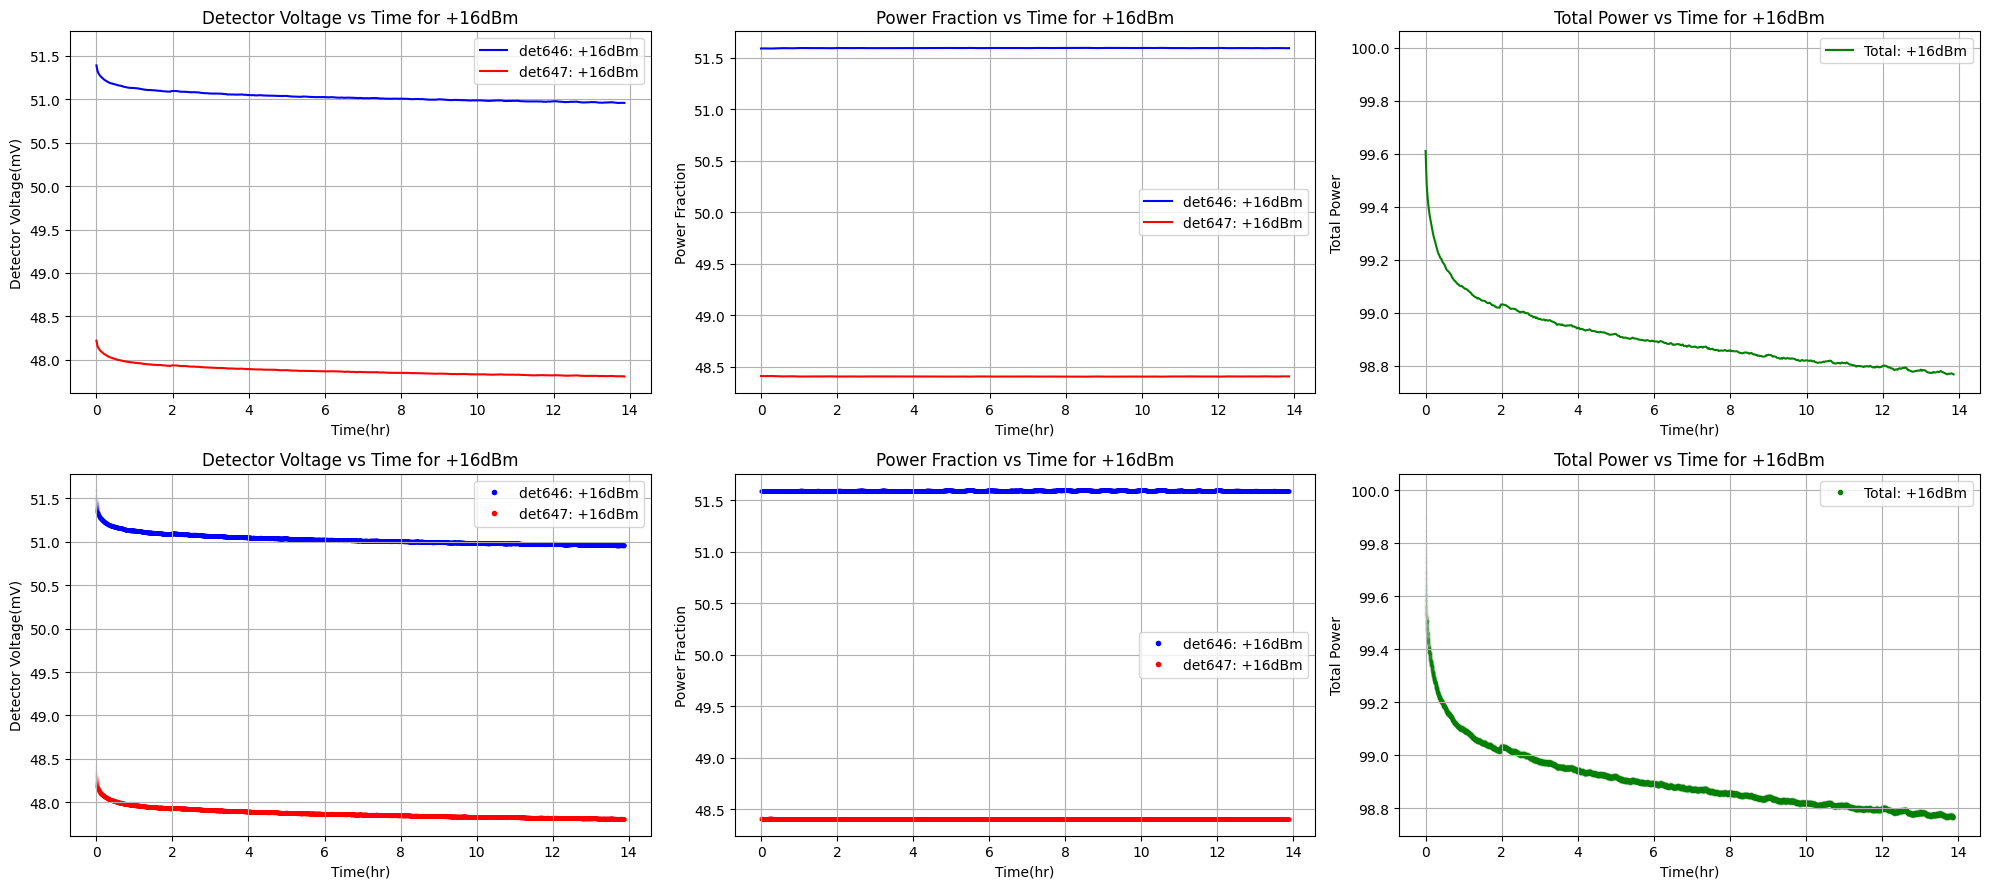

In [6]:
SeriesPlot(ver='v8', PWR='+16', sampling_freq=1, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=50e-3, figsize=(20,9), alpha=0.025, size=4, normalized=Normv6, timescale='hours')

There are 50000 Points In Total
The Sampling Rate is 1Hz
Aperture is 50 ms
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are hours
Signal Is Normalized



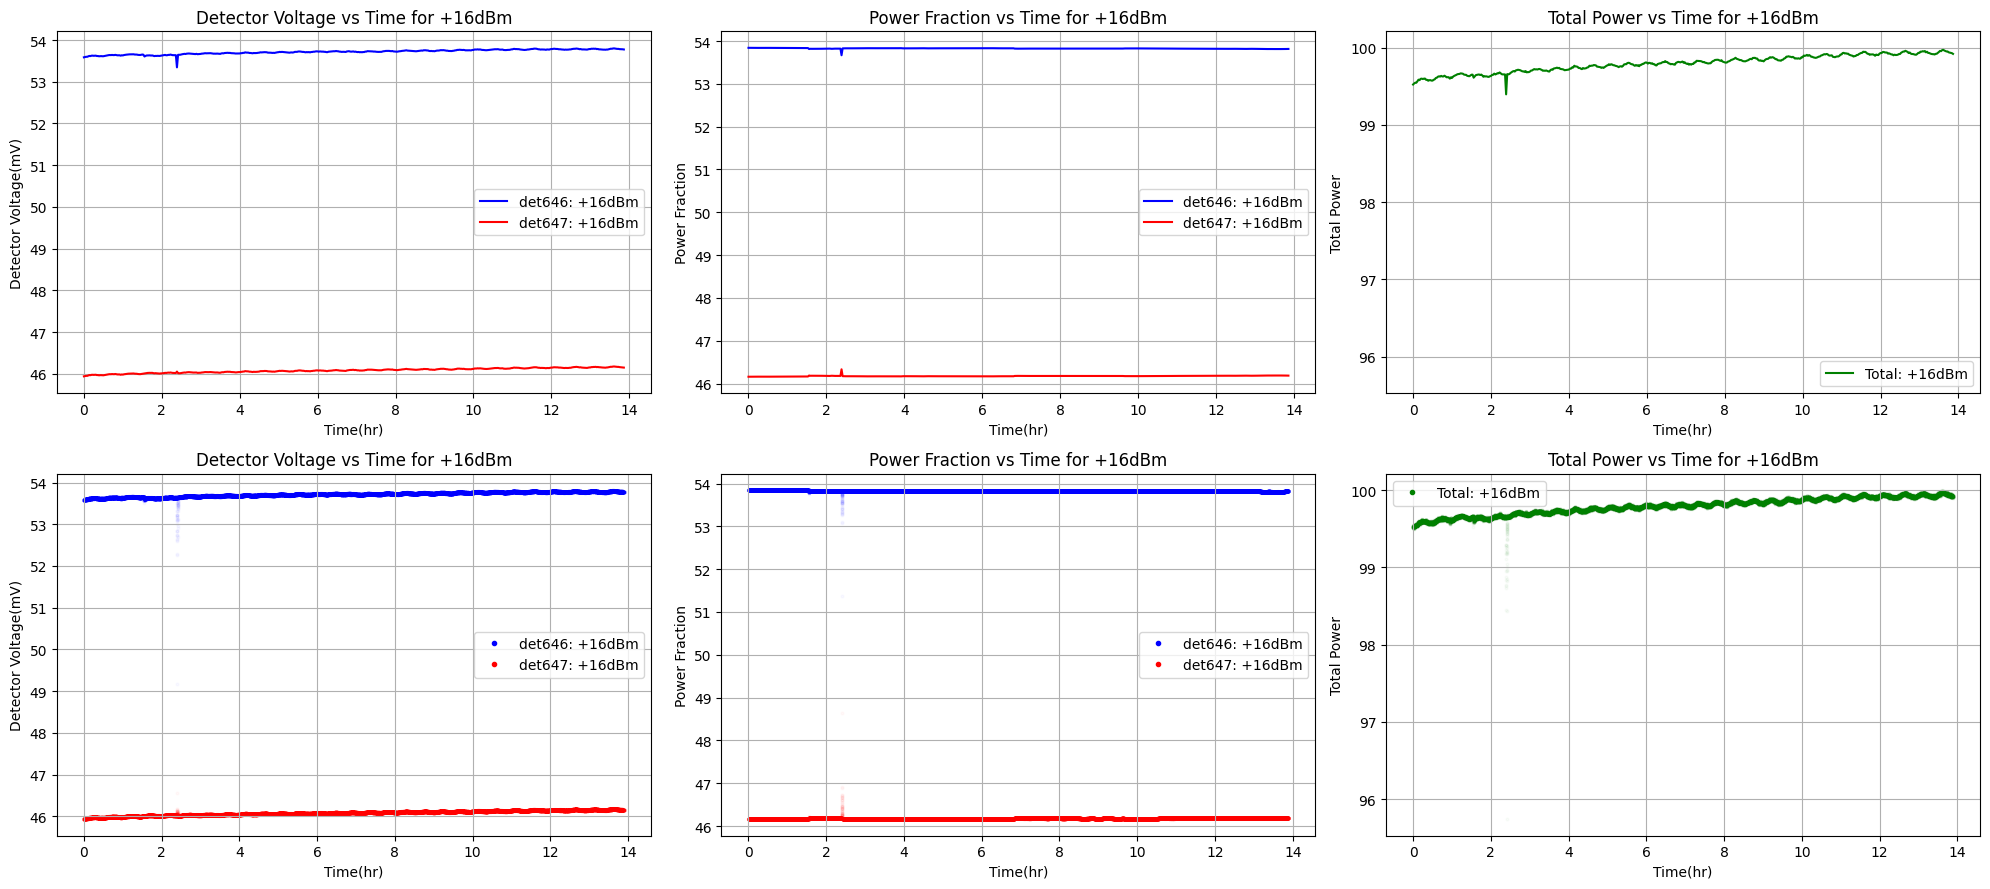

In [7]:
SeriesPlot(ver='v9', PWR='+16', sampling_freq=1, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=50e-3, figsize=(20,9), alpha=0.025, size=4, normalized=Normv6, timescale='hours')

## 2 way splitter, misc

In [8]:
#v10 source a 16dBm splitter basic
#16dBm start 09:26 7/23
#v11 long series steady interferometer setup splitter phase QH 1
#16dB, start 13:31 7/23

There are 50000 Points In Total
The Sampling Rate is 7Hz
Aperture is 5 ms
Line Plots Averaging Every 100 Points
Scatter Plots Averaging Every 1 Points
Timescale units are hours
Signal Is Normalized



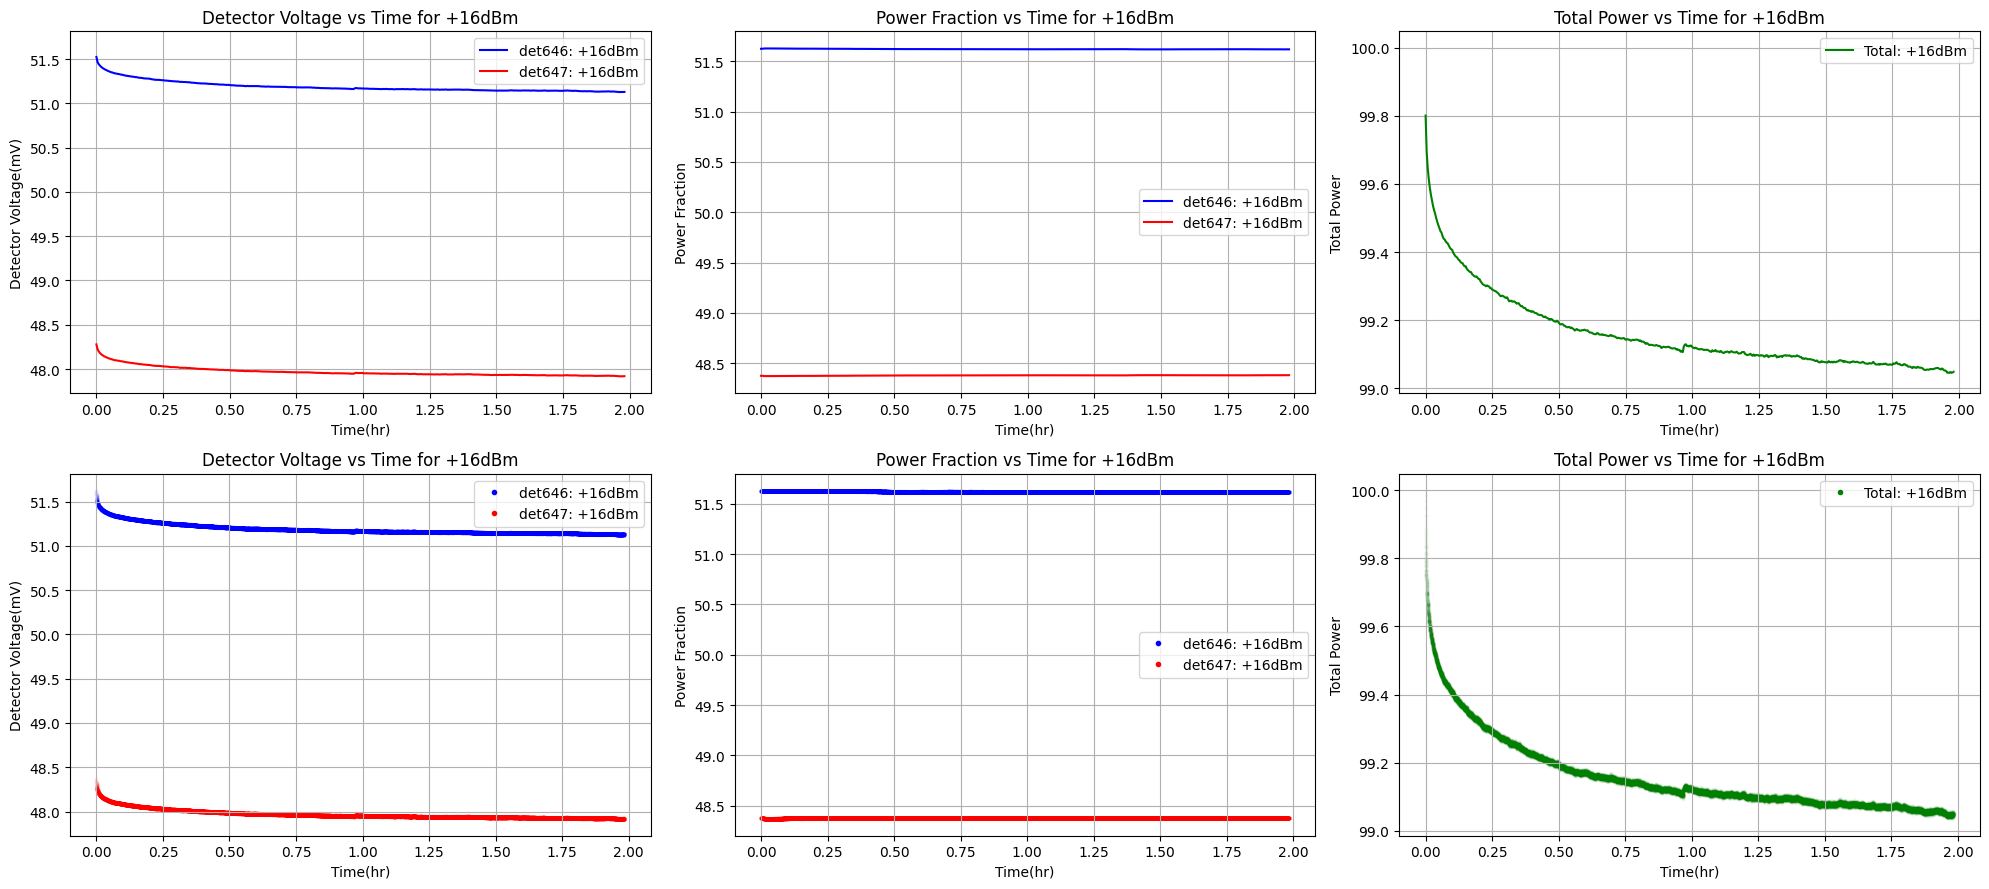

In [9]:
SeriesPlot(ver='v10', PWR='+16', sampling_freq=7, Slice_Size=100, Scatter_Slice=1, n=50000, aperture=5e-3, figsize=(20,9), alpha=0.025, size=4, normalized=Normv6, timescale='hours')

In [10]:
#Start 09:45 7/24
#v11 is after source on for a long time, a power outage may have occured
#v13 12:20 7/24
#10dBm attenuation

In [11]:
Normv7 = False

In [12]:
#Labels and titles and multiple graphs
#Adjustable bounds
#Sampling 1k

## Phase Noise

Here I am sweeping through the manual phase shifter positions with the source connection to a 2way splitter, and then the two outputs connected to a QH, with a manual phase shifter on one arm, 2 detectors are connected to each output slot of the QH

This first data (v11) had glitches

Aperture is 50 μs
1000 Points Per Meter Value
Signal Is Not Normalized



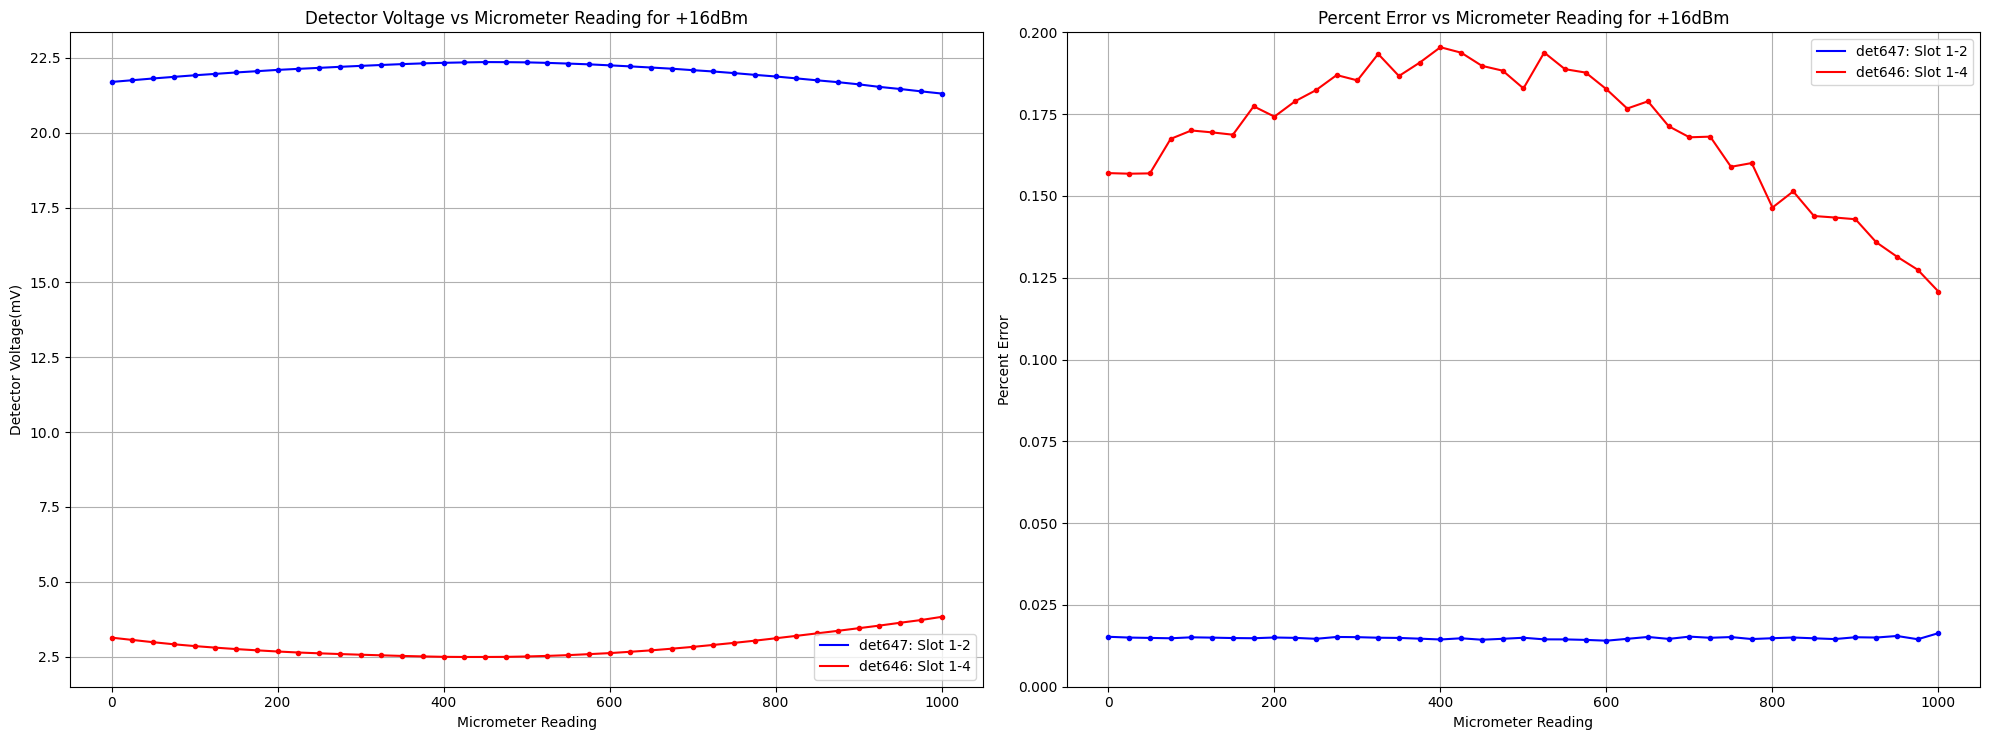

In [13]:
PhaseNoisePlot(ver='v11', PWR='+16', errmax=0.2, Slice_Size=1000, aperture=50e-6, figsize=(20,7.5), normalized=Normv7)

There are 1000 samples at each meter value for the one below, and then 10000 per for the one below that

Aperture is 50 μs
1000 Points Per Meter Value
Signal Is Not Normalized



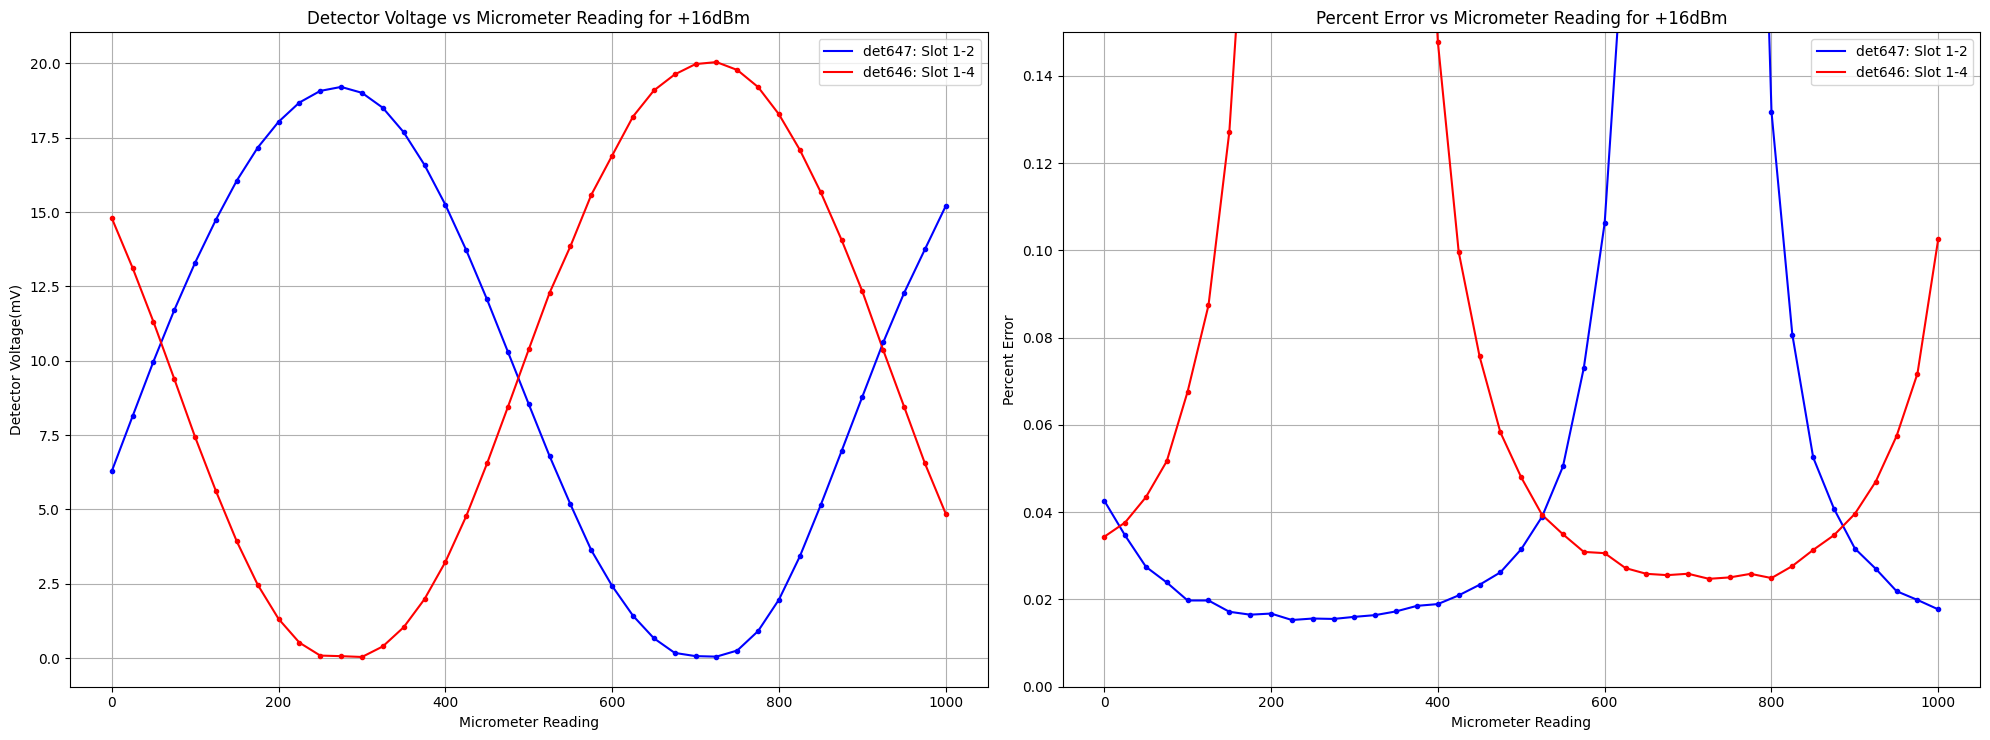

In [14]:
PhaseNoisePlot(ver='v12', PWR='+16', errmax=0.15, Slice_Size=1000, aperture=50e-6, figsize=(20,7.5), normalized=Normv7)

Aperture is 50 μs
10000 Points Per Meter Value
Signal Is Not Normalized



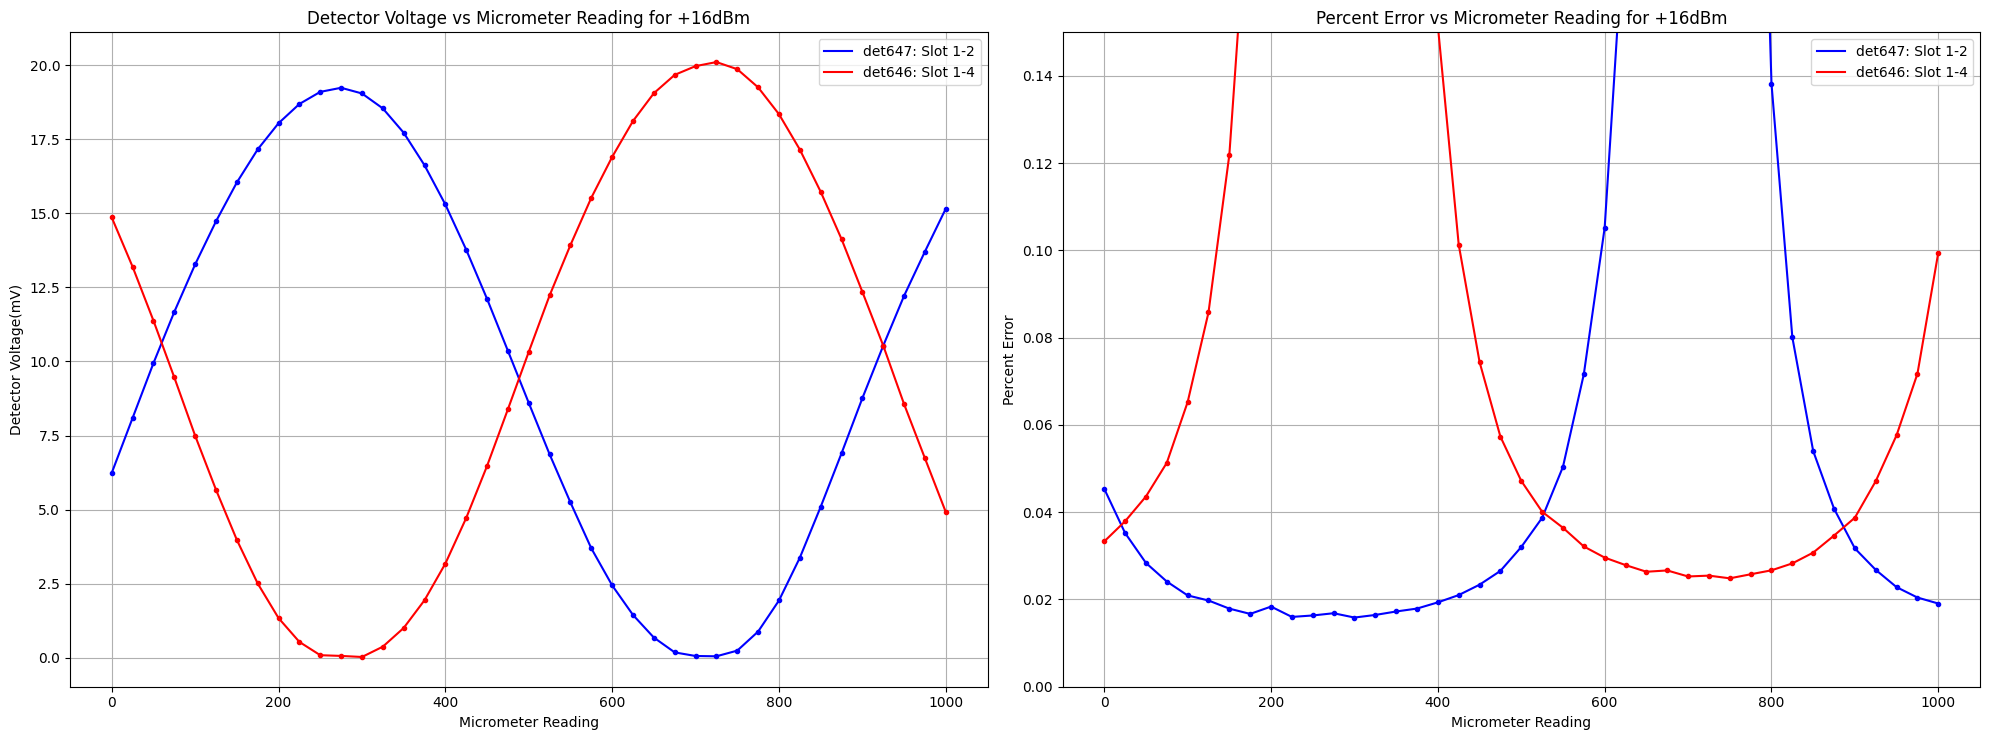

In [15]:
PhaseNoisePlot(ver='v13', PWR='+16', errmax=0.15, Slice_Size=10000, aperture=50e-6, figsize=(20,7.5), normalized=Normv7)

In [16]:
#Try different powers, attenuation and not attenuation, try amplification circuit, source B, and different detectors, maybe try the spectrum analyzer for some power measurements
#Maybe look at each source output in spectrum analyzer

In [17]:
#20dBm with attenuation v12 -

The power is changed from +16dBm to +20dBm, with 10dB attenuation for v12 and none for v13

Aperture is 50 μs
1000 Points Per Meter Value
Signal Is Not Normalized



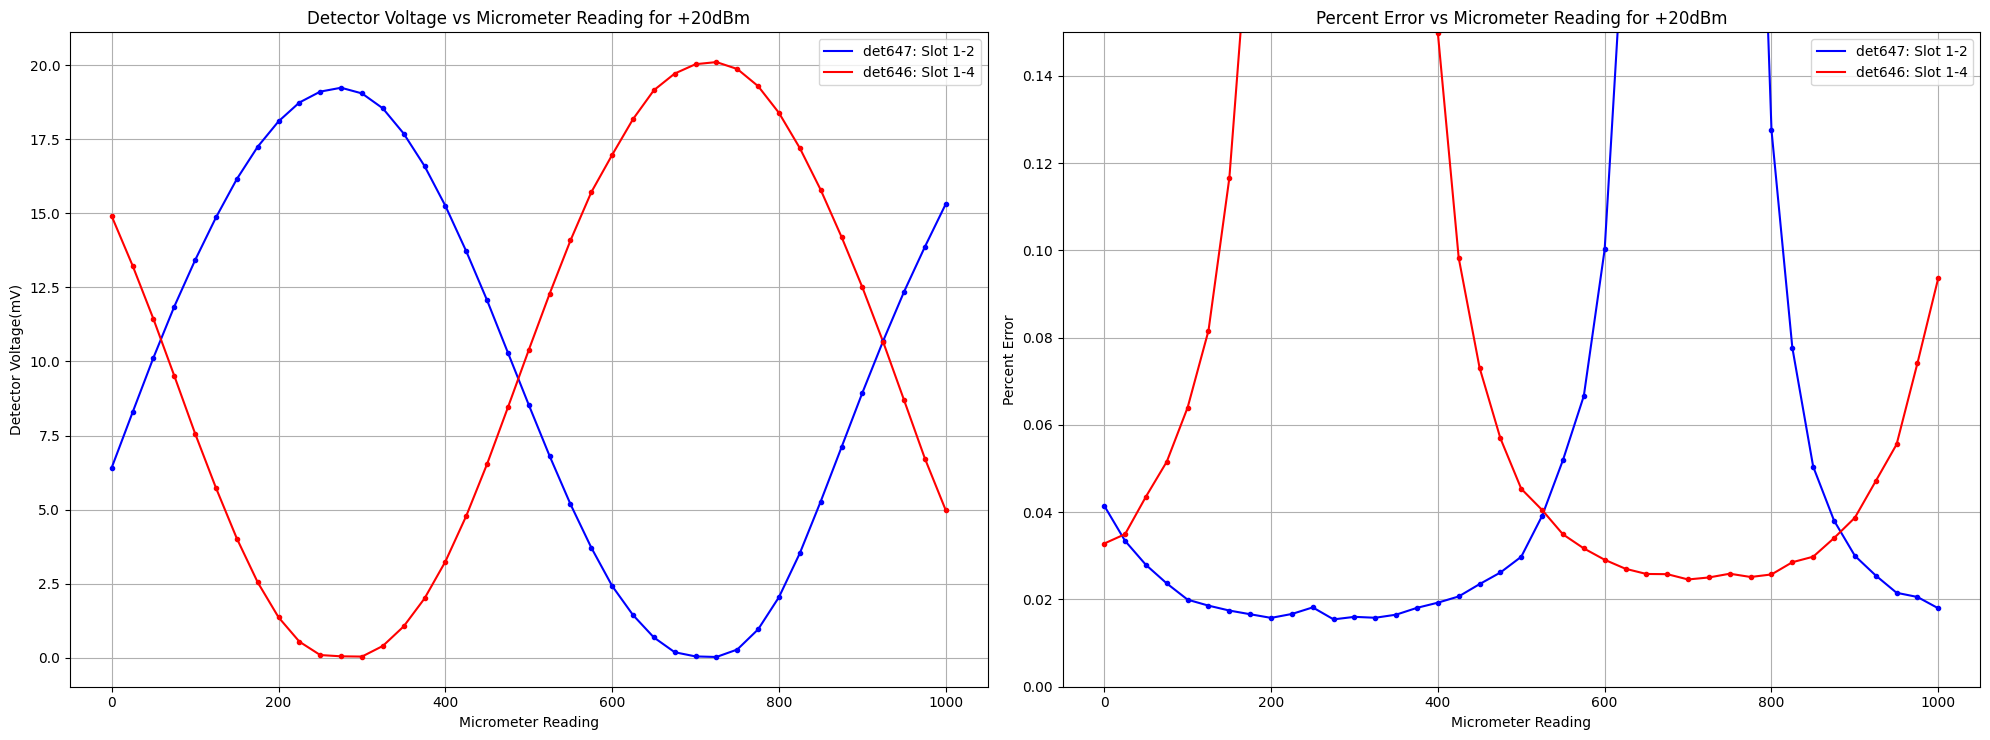

In [18]:
PhaseNoisePlot(ver='v12', PWR='+20', errmax=0.15, Slice_Size=1000, aperture=50e-6, figsize=(20,7.5), normalized=Normv7)

In [19]:
#v13 20dBm has no attenuation, starts 10:00 7/26

Aperture is 50 μs
1000 Points Per Meter Value
Signal Is Not Normalized



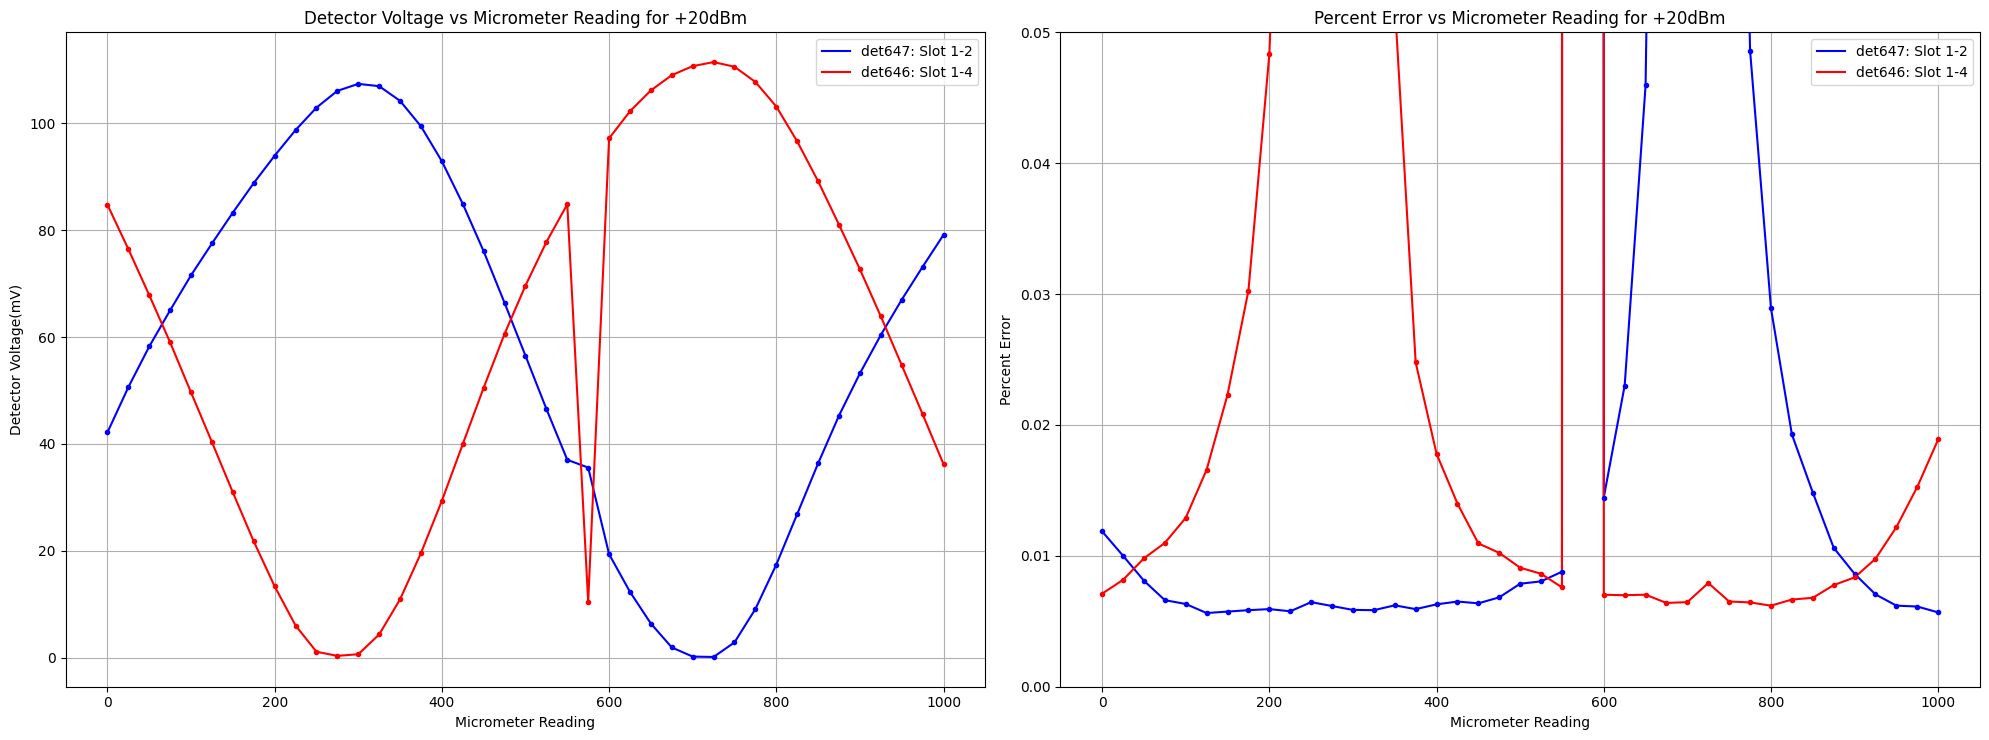

In [20]:
PhaseNoisePlot(ver='v13', PWR='+20', errmax=0.05, Slice_Size=1000, aperture=50e-6, figsize=(20,7.5), normalized=Normv7)

This plot shows the best error pedestal we have seen of under 1 part in 10000

In [21]:
#Try amplification circuit, make sure detectors are predictable in this range without attenuation,
#Checks changing digit readings, try amplification circuit.